In [ ]:
"""
In this notebook there are four main cells

Cell 1 creates a QUBO Adjacency to represent the ambulance problem, it involves constraints and minimising distance driven.
Cell 2 Defines the methods used in Cell 3, and converts QUBO Adjacency to the dwave type bqm that can be sampled 
Cell 3 Finds the minimum energy for a given starting postion of two ambulances, using a choice of a) dimod.ExactSolver() b)neal.SimulatedAnnealingSampler()   or c) DWaveSampler() the live QPU not a simulator
cell 4 iterates over all possible starting position of two ambulances and selects the lowest energy of them all and which destination are allocated to each of the two ambulances.

In [1]:
import neal
solver = neal.SimulatedAnnealingSampler()  

hi from SimulatedAnnealingSampler


ImportError: DLL load failed: The specified module could not be found.

In [1]:
#TWO AMBULANCE DISTANCE MINIMISATION - 

import numpy as np 
#RC utility functions    
from pyaqc.RCModules.PlatformConversion import print_QUBOdetails, CreateTwoAmbulanceAdjacencyV1,CreateTwoAmbulanceAdjacencyV2
#################################### Create Adjacency defined as a qubo ####################################
n_destinations = 25  
gridWidth = 5# n_destinations
Width  = gridWidth
Height = n_destinations//gridWidth

result = CreateTwoAmbulanceAdjacencyV2(gridWidth,n_destinations, Adddistance = 1,use_XYMixer_constraints=0)

Adjacency = result['qubo']
AdjacencyHybrid = result['quboHybrid']
n_qubits = result['n_qubits']
ConstraintMultiplier = result['ConstraintMultiplier']
max_distance = result['max_distance']

if 0:
    filename = 'Twoambulances.txt'
    print_QUBOdetails(Adjacency,n_qubits,filename)

In [2]:
#Myqubo = dimod.BinaryQuadraticModel.from_ising(linear, quadratic,n_qubits)      #the length of linear defines the number of qubits in the qubo
import matplotlib.pyplot as plt
from datetime import datetime
from pyaqc.RCModules.TwoAmbulanceAnalysis import *


import dimod 
Myqubo = dimod.BinaryQuadraticModel.from_qubo(Adjacency)
samplerExact = dimod.ExactSolver()

def create_hybrid_from(Adjacency, Nlocs,A0_fix ,A1_fix ):
    """
    returns (Type:dict) A simplified adjacency table, (a subproblem) that uses a fixed starting position for each ambulance
    """
    for L in range(0 , Nlocs):
        # remove AdjacencyHybrid distance references
        if (L, 2*Nlocs) in AdjacencyHybrid:
            del AdjacencyHybrid[(L, 2*Nlocs)] 
        if (L + Nlocs, 2*Nlocs +1) in  AdjacencyHybrid:
            del AdjacencyHybrid[(L + Nlocs, 2*Nlocs +1)] 
        
        # add first ambulance distances from fixed start to each destinations (if non-zero)
        A0_fix_to_des_key = (L, A0_fix + 2 * Nlocs) 
        if (A0_fix_to_des_key) in  Adjacency:
            AdjacencyHybrid[(L, 2*Nlocs)] = Adjacency [A0_fix_to_des_key]                 
        # then second ambulance
        A1_fix_to_des_key = (L + Nlocs, A1_fix + 3 * Nlocs )
        if (A1_fix_to_des_key) in  Adjacency:
            AdjacencyHybrid[(L + Nlocs, 2*Nlocs +1)] = Adjacency [A1_fix_to_des_key]       
    return AdjacencyHybrid
from dwave.cloud import Client
client = Client.from_config(token='DEV-d58203bae0f10bbf7a7bec839b170624758a9d5d')       #my actual token
client.get_solvers()

[UnstructuredSolver(id='hybrid_binary_quadratic_model_version2'),
 StructuredSolver(id='DW_2000Q_6'),
 StructuredSolver(id='Advantage_system1.1')]

0 = Time taken (secs) by simAnneal
-8547.0  = Lowest energy found by simAnneal  in a grid 5 (w) by 5 (h)
Destination Constraints were Met.
 Map of destinations of each ambulance, 1 for A0, 0 for A1. Where A0 starts add 10, A1 add 20
[1, 1, 1, 1, 0]
[0, 1, 11, 1, 1]
[1, 1, 0, 0, 1]
[0, 0, 20, 0, 0]
[1, 0, 0, 1, 0]
Distance of solution =  93	With A0_sol = 7 and A1_sol = 17
 ConstraintMultiplier/max_distance =  10.0
Grid            Energy          Distance       Constraintmet  Method         Lagrange K     num_reads      time           
|5  * 5|       -8547.0|             93|                   1|      simAnneal|            10.0|              9|              0|


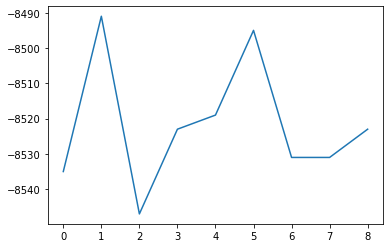

In [3]:
#This cell creates a Ising model, from a qubo defined adjacency, where the starting positions of the two  ambulances have been specified by the user
# eg Amulance 'zero' starts location number 4 so set A0_fix=4
#Then this cell finds the lowest energy waveform using one of three different minimisation approaches    
#Cell 3 Finds the minimum energy for a given starting postion of two ambulances, using a choice of a)dimod.ExactSolver() b)neal.SimulatedAnnealingSampler()   or c) DWaveSampler()

################# Main minimisation of the subproblem #################
tstart = datetime.now()
if Height==2 and Width==2:
    A0_fix = 1
    A1_fix = 2
if Height==3 and Width==3:
    A0_fix = 1
    A1_fix = 7
if Height==5 and Width==5: #On inspection 7, 17 is the optimized distance start positions for 5*5
    A0_fix = 7 #22                          # a 10*5 grid has a more obvious solution by inspection 22,27
    A1_fix=  17 # 27#  16,32  40  
if Height==7 and Width==7:      #I need to check this is the optimum position of the ambulances
    A0_fix = 16
    A1_fix = 32                   
ConstraintMet = 1
Nlocs = Height*Width
psi_opt =[]
MinE = 0
ψ = []
Method= 'sampler'

UseHybrid = 1

Num_readsMy = 9#000      # SolverFailureError: The parameter num_reads must be within [1, 10000]
if UseHybrid:
    AdjacencyHybrid = create_hybrid_from(Adjacency, Nlocs,A0_fix ,A1_fix )
    Myqubo = dimod.BinaryQuadraticModel.from_qubo(AdjacencyHybrid)       #use quboHybrid with given A0_fix and A1_fix
else:
    Myqubo = dimod.BinaryQuadraticModel.from_qubo(Adjacency)             #use Adjacency with all starting positions

############ Use one of three possible samplers
    # a)samplerExact(calculated every possible combination of ambulance start positions)
    # b)SimulatedAnnealingSampler()  (classically imitates a Dwave annealer)
    # c)sampler = EmbeddingComposite(DWaveSampler()) , the real online Dwave annealer

if 0:       # a)
    response = samplerExact.sample(Myqubo) 
    Num_readsMy = 1
    energy = response.first[1]
    Method = 'samplerExact'
    
elif 1:
    Method = 'simAnneal'
    import neal
    solver = neal.SimulatedAnnealingSampler()  
    response = solver.sample(Myqubo, num_reads=Num_readsMy)
    plt.plot(response.data_vectors['energy'])
elif 1: 
    # DWAVE online annealing 
    Method = 'DWAVEQPU'
    from dwave.system.samplers import DWaveSampler
    from dwave.system.composites  import EmbeddingComposite
    sampler = EmbeddingComposite(DWaveSampler())                                    
    response = sampler.sample(Myqubo, num_reads=Num_readsMy)
TimeTaken = (datetime.now() - tstart).seconds
print(TimeTaken, '= Time taken (secs) by', Method)    

# Find Start positions in the solution
psi_opt = list( response.first[0].values())
if not UseHybrid:
    A0_sol  =   Grid_StartPositionsAO(psi_opt,  Height,Width)
    A1_sol  =   Grid_StartPositionsA1(psi_opt,  Height,Width)
else:
    A0_sol = A0_fix
    A1_sol  = A1_fix
Print_Destinations(response, Height,Width,Method, A0_sol, A1_sol,show_start_pos=1)
if A0_sol>=0 and  A1_sol>=0:
    Distance = SolutionDistance(psi_opt,A0_sol,A1_sol,Adjacency,Nlocs)
    print('Distance of solution = ', Distance, end='')
else:
    print('Start positions not found')
    Distance = -1
print( '\tWith A0_sol =',A0_sol,'and A1_sol =',A1_sol)
print( ' ConstraintMultiplier/max_distance = ', ConstraintMultiplier/max_distance  )
print(              '{:15} {:15} {:15}{:15}{:15}{:15}{:15}{:15}'.format('Grid','Energy', 'Distance', 'Constraintmet','Method', 'Lagrange K', 'num_reads ', 'time'),end=''  )
print("\n|{:<2} {:<1}{:<1}|{:>14}|{:15}|{:>20}|{:>15s}| {:15}|{:15}|{:15}|".format(Width,'* ',Height,response.first[1],Distance,ConstraintMet, Method,ConstraintMultiplier/max_distance,Num_readsMy,TimeTaken) )

In [ ]:
print()

# How frequently was this energy level found?

Aggregate each experiment by the sample solution, then classically sort solutions in order of lowest energy, and look up how many times that sample, or another sample of the same energy was found:

In [16]:

print(response.aggregate().first[1], ' = lowest energy found' )
print(sum(response.lowest(atol=.1).data_vectors['num_occurrences']), " = number of occurances of the lowest energy found. Using num_shots =  {0:4} ".format( Num_readsMy )  )
print('%3.2f'%(sum(response.lowest(atol=.1).data_vectors['num_occurrences'])*100/Num_readsMy), '= % Probability that this energy level was found by one anneal, ie num_shot=1')
print(len(response.data_vectors['energy']), 'len (List of  energies UNORDERED)')

-8575.0  = lowest energy found
1  = number of occurances of the lowest energy found. Using num_shots =  50000 
0.00 = % Probability that this energy level was found by one anneal, ie num_shot=1
50000 len (List of  energies UNORDERED)


In [ ]:
"""
Record of actual problems submitted on line ie to the DWAVEQPU compared to the SimulatedAnnealingSampler

DWAVEQPU solutions:
#4*3 solution, this means W=4 and H=3 hence there are 12 possible locations to start from.
  0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1] = psi_opt first ambulance destinations 
 [1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0] = psi_opt 2nd ambulance destinations -7690.0 in 15 msecs
DWAVEQPU num_shots = 10000 is too many
 
 
 9*9                    1858         yes        DWAVEQPU       sum_distance              20            16ms
 10*10      embedding found(10*10*2+2= 202)      more qubits than 7*7*4
 11*11      embedding found(11*11*2+2= 244)      more qubits than 7*7*4  so perhaps highly connected nature of start/distance is problem
A0_fix = 22 A1_fix = 27 I have found best Distance of solution for 11*11, by inspection, = 200 

A0 and A1 not fixed 9.189sec  

7*7         no embedding found (7*7*4 = 196) 7203 (= 49*49 *3 ) edge weightings
9*9         no embedding found (9*9*4 = 324)    DWAVEQPU       sum_distance              20            18

A0 and A1 not fixed
5*5         embedding found(5*5*4=100, 1875 Edges)     DWAVEQPU       sum_distance       20            18
5*5        -134894.0   106                      simAnneal   sum_distance                  100
5*5        -134906.0   94                       simAnneal   sum_distance                  1000
5*5        -134918.0   82                       simAnneal   max_distance *10              1000


7  * 7      -18030.0            330                   1      simAnneal             5.0           9000              1
7*7                             338                           simAnneal   max_distance *10              9000
7*7          -36370.0           360         y               simAnneal       max_distance *10              9000   (? occurance)               
A0_fix = 16 A1_fix = 32 12.35pm
9*9   -14520154.0       1526      yes           simAnneal   sum_distance                  1000
A0_fix = 22 A1_fix = 27 I have found best Distance of solution, by inspection, = 200 
10*5                    450       yes           simAnneal   sum_distance                  50000
10*5                    425       yes           simAnneal   sum_distance                  50000
10*5                    385       yes           simAnneal   max_distance *10              50000
10*5                    365       yes           simAnneal   max_distance *10              50000
"""



In [ ]:
Fixed starting positions ie UseHybrid = 1
Grid            Energy          Distance       Constraintmet  Method         Lagrange K     num_reads      time 

3  * 3        -871.0  (11.7%)            9                   1       DWAVEQPU            10.0           9000              5

In [5]:
# To reduce the qubits used, select the ambulance STARTING POSITIONS, (n(n-1))/2 of them, CLASSICALLY , calc each energy with dwave pick the lowest.
from dwave.system.samplers import DWaveSampler
from dwave.system.composites  import EmbeddingComposite
            
Nlocs = Height*Width
psi_opt =[]
MinE = 0
A0_sol = -1
A1_sol = -1
from datetime import datetime
tstart = datetime.now()
#Create a set of smaller subproblems each called 'AdjacencyHybrid' each derived from a fixed starting position of each ambulance A0_fix and A1_fix

for A0_fix in range(0,Nlocs):
    for A1_fix in range(A0_fix +1 ,Nlocs):
        AdjacencyHybrid = create_hybrid_from(Adjacency, Nlocs,A0_fix ,A1_fix ) 
        #2) Find the lowest energy of the subproblem
        Myqubo = dimod.BinaryQuadraticModel.from_qubo(AdjacencyHybrid)
        if 0: 
            response = samplerExact.sample(Myqubo) 
            Method = 'samplerExact'
        elif 1:
            Method = 'simAnneal'
            import neal
            solver = neal.SimulatedAnnealingSampler()  
            response = solver.sample(Myqubo, num_reads=Num_readsMy)
        elif 0: 
            # DWAVE online annealing Lesson 4
            sampler = EmbeddingComposite(DWaveSampler())                                    
            response = sampler.sample(Myqubo, num_reads=Num_readsMy)
            Method = 'DWAVEQPU'
        
        Distance = SolutionDistance(response.first[0],A0_fix,A1_fix,Adjacency,Nlocs)
        show_grid = 1
        if  not show_grid:
            ψ  = list( response.first[0].values() )
            print('',ψ[:Width * Height],              '= ψ  first ambulance destinations')
            A_start =[ int(not bool(n-A0_fix)) for n in range(Nlocs)]
            print(A_start , ' = start position of AO')
            print(ψ[Width * Height:2*Width * Height], '= ψ  2nd ambulance destinations', response.first[1], 'Distance = ',Distance,'\n')
            A_start =[ int(not bool(n-A1_fix)) for n in range(Nlocs)]
            print(A_start , ' = start position of A1')
        else:
            if 0:
                ψ  = Print_Destinations(response, Height,Width,Method)
            print( 'Distance = ',Distance)
            
        # print('Use both ambulance1;', datum.sample[Width * Height*2],'and ambulance2;',datum.sample[Width * Height*2+1])
        energy = response.first[1]              #This is the lowest energy found by the
        if MinE > energy:
            best_response = response
            ψ =     list( response.first[0].values() )        #a list of the waveform evaluated
            MinE = energy
            E = qubo_energy_value(ψ, AdjacencyHybrid)
            psi_opt = ψ
            A0_sol = A0_fix
            A1_sol  = A1_fix
            print(psi_opt, MinE,' A0pos =',A0_sol,' A1pos =',A1_sol, 'Distance = ',Distance )
            print((datetime.now() - tstart).seconds, '= seconds elapsed')   
#Print lowest energy from the set of all starting positions
Distance = SolutionDistance(best_response.first[0],A0_sol ,A1_sol,
print( '(Distance travelled)^2 by ambulances in solution to objective function = ',Distance)Adjacency,Nlocs)
ψ  = Print_Destinations(best_response, Height,Width,Method)

print('\nAfter ', (datetime.now() - tstart).seconds, 'seconds, Final psi:')

print('finished hybrid')

Distance =  18
[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1] -862.0  A0pos = 0  A1pos = 1 Distance =  18
1 = seconds elapsed
Distance =  18
Distance =  18
Distance =  10
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] -870.0  A0pos = 0  A1pos = 4 Distance =  10
7 = seconds elapsed
Distance =  11
Distance =  18
Distance =  11
Distance =  14
Distance =  18
Distance =  13
Distance =  9
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1] -871.0  A0pos = 1  A1pos = 4 Distance =  9
18 = seconds elapsed
Distance =  13
Distance =  11
Distance =  9
Distance =  11
Distance =  11
Distance =  10
Distance =  18
Distance =  14
Distance =  11
Distance =  18
Distance =  9
Distance =  9
Distance =  18
Distance =  13
Distance =  11
Distance =  9
Distance =  10
Distance =  9
Distance =  10
Distance =  11
Distance =  13
Distance =  18
Distance =  18
Distance =  18
Distance =  18


TypeError: SolutionDistance() takes 5 positional arguments but 6 were given

In [10]:
print( '(Distance travelled)^2 by ambulances in solution to objective function = ',Distance)Adjacency,Nlocs)
ψ  = Print_Destinations(best_response, Height,Width,Method)


-871.0  = Lowest energy found by simAnneal  in a grid 3 (w) by 3 (h)
Destination Constraints were Met. 
 Map of destinations of each ambulance, 1 for A0, 0 for A1
[1, 1, 1]
[0, 0, 0]
[0, 0, 0]
(Distance travelled)^2 by ambulances in solution to objective function =  9


In [ ]:
"""         
Grid        features    qubits  2^n            Method      Energy solution         Time/hours               Comment
3*2         *4           24     2^24 = 16m      dimod       -2367=-2374+9           2mins
3*2         *4           24     2^24 = 16m      C++         -2367=-2374+9           15mins               not faster than dimod

3*3         *4          = 36    2^36 = 69bn     C++         -2367=-2374+9           69bn/20m = 3500mins
3*3         *2 +2       = 20    (9*8)2^20 = 16m dimod/hybrid -2367=-2374+9          4 mins

c++ and ipynb gives E = -2367 = -2374 + 9 by symmetry the solution is clear so I tested that the Ising was low 
"""



In [19]:
print('CLASSICAL calculation of energies using dimod and qubo_energy_value() which should equal each other')
print('Location grid is ',Width,'wide and ',Height,'high.' )
Myqubo = dimod.BinaryQuadraticModel.from_qubo(qubo)
#THIRD calculate ENERGY of each state
tstart = datetime.now()
################ (A) calculate energy of one input state, using if 1 ################
if 0:
    #Below are three ψ solutions for location grids of 2*2, or 3*2, or 3*3 
    ψ = [1, 1, 1, 0, 0, 0, 0, 0,  0,1, 1, 1,0 ,1, 0, 0, 1, 0]  #16 qubits 2*2*4 = 16 qubits
    #   des_a0              des_a1              START_A0            START_A1
    #   0                   6                   12                  18
    ψ = [1, 1, 1, 0,0, 0   , 0, 0, 0,1, 1, 1,   1,0, 0, 0, 0, 0,    0,0, 0, 0, 1, 0]  #2*2,
    
    ψ = [1, 1, 1,1,1,0,0,0,0   , 0,0,0,0,0,1,1,1,1,   0,1,0,0,0,0,0,0,0,    0,0,0,0,0,0,0,1,0] #grid 3*2*4

    #ψ =[1, 1, 1, 0, 0, 0, 0, 0, 0  , 0, 0, 0, 1, 1, 1, 1, 1, 1,   1, 1] hybrid 3*3 gives E = -2367 takes 6 mins(3.5min not in debug mode or .ipynb) with energy = response.first[1]
    #...but 2.3 hrs with "enumerate" cycling through every energy level was costly
    E = qubo_energy_value(ψ, qubo)
    
    print('\t\t\t\t',ψ[:Width * Height],'= ψ first ambulance destinations','\n','\t\t\t\t',ψ[Width * Height:2*Width * Height],'= ψ 2nd ambulance destinations \t')
    print(ψ[2*Width * Height:3*Width * Height],'= ψ first ambulance Start position',ψ[3*Width * Height:4*Width * Height],'= ψ 2nd ambulance Start position\t', '%3.2f' %E,'= classical Energy')
else:
    ################ or (B) calculate energy of all input state, using if 0 ################
    response = samplerExact.sample(Myqubo) 
    stop =0 
    max_sol = 0
    MinE = -10000

    for n,datum in enumerate( response.data(['sample', 'energy'])):     
        if  n < 30 or 0:                                 #display lowest energy results
            for i, elem in enumerate( datum.sample):
                ψ[i] = (datum.sample[elem]) 
            #Check if Dwave energy calculation is the same as my calculation qubo_energy_value()
            E = qubo_energy_value(ψ, qubo)
    # print ERROR if the constraints have not been met. The target is for just one start postion per Ambulance, every location to be designated just one ambulance         
            if max(ψ[:Width * Height]+ ψ[Width * Height:2*Width * Height]) >1:
                print('ERROR',ψ[:Width * Height],'= ψ first ambulance destinations','\n',ψ[Width * Height:2*Width * Height],'= ψ 2nd ambulance destinations \t')
            if sum(ψ[3*Width * Height:4*Width * Height]) !=1 and sum(ψ[2*Width * Height:3*Width * Height]) !=1 and stop <20 :
                stop +=1
                print('ERROR',ψ[2*Width * Height:3*Width * Height],'= ψ first ambulance Start position',ψ[3*Width * Height:4*Width * Height],'= ψ 2nd ambulance Start position\t', '%3.2f' %E,'= classical Energy', '%3.2f' %datum.energy,'= DIMOD calc of energy n=',n)
    #print position of Ambulance start positions and destinations. 
            if MinE < datum.energy or  max_sol <5:
                max_sol += 1
                MinE = datum.energy
                print('\t\t\t\t',ψ[:Width * Height],'= ψ first ambulance destinations','\n','\t\t\t\t',ψ[Width * Height:2*Width * Height],'= ψ 2nd ambulance destinations \t')
                print(ψ[2*Width * Height:3*Width * Height],'= ψ first ambulance Start position',ψ[3*Width * Height:4*Width * Height],'= ψ 2nd ambulance Start position\t', '%3.2f' %E,'= classical Energy', '%3.2f' %datum.energy,'= DIMOD calc of energy n=',n)
print((datetime.now() - tstart).seconds)
print('Finished non-hybrid')


CLASSICAL calculation of energies using dimod and qubo_energy_value() which should equal each other
Location grid is  2 wide and  2 high.


IndexError: list assignment index out of range

    After about 1 hour it completed a 3*2 grid with 4 features, roughly 16m calcs, successfully finding the -524 energy that I expected from the simplicity of the problem. An ambulance in each corner service itself and its two neighbour represents an energy of 4 from the distance covered.

